# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

We are looking to predict salaries based on a number of different features so that we can recommend tactics to people to get higher salaries.

In [1]:
# import your libraries
import numpy as np  # Linear Algebra
import matplotlib.pyplot as plt  # Plotting
import pandas as pd # Dataframes
import seaborn as sns  # Wrapper for Matplotlib to give nicer plots
import sklearn as sklearn  # Scikit-learn

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from tqdm.notebook import tqdm  # Progress bars for the impatient


%matplotlib inline
sns.set(style="whitegrid")
sns.set_context(context=None, font_scale=1, rc=None)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 32

# your info here
__author__ = "Tom Halloin"
__email__ = "tomhalloin@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
# load the data into a Pandas dataframe
train_features = pd.read_csv('../Data/train_features.csv')
train_salaries = pd.read_csv('../Data/train_salaries.csv')
test_features = pd.read_csv('../Data/test_features.csv')

### ---- 3 Clean the data ----

<ol>
    <li>Merge features with salaries to ensure one-to-one relationship until modeling time.</li>
    <li>Change jobId to an integer.</li>
    <li>Remove "Comp" in front of company_ID to change to an integer.</li>
    <li>Changing data types to compress size of dataset.</li>
    <li>Establish jobId as an index.</li>
</ol>

Merge features with salaries to ensure one-to-one relationship until modeling time. 

In [3]:
train_combined = train_features.merge(train_salaries, on='jobId')

Create two functions: clean_jobID to use the Job ID as an index, and remove the comp part of Company ID in front.

In [4]:
def clean_jobId(job):
    """Cleans jobID string so that it can be an integer to use as an index."""

    jobId = int(job.replace("JOB", ""))
    return jobId


def clean_companyId(company):
    """Cleans companyID string to remove comp in front."""

    companyID = company.replace("COMP", "")
    return companyID

Apply functions stated above.

In [5]:
train_combined['jobId'] = train_combined['jobId'].apply(clean_jobId)

Check data types for anything unusual and change Dtype to more specific types to save space.

In [6]:
train_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  int64 
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 76.3+ MB


Changing data dtypes. ID's are going to be converted to integers for plotting purposes.

In [7]:
train_combined['jobId'] = train_combined['jobId'].astype('int32')
train_combined['companyId'] = train_combined['companyId'].astype('category')
train_combined['jobType'] = train_combined['jobType'].astype('category')
train_combined['degree'] = train_combined['degree'].astype('category')
train_combined['major'] = train_combined['major'].astype('category')
train_combined['industry'] = train_combined['industry'].astype('category')
train_combined['yearsExperience'] = train_combined['yearsExperience'].astype(
    'int32')
train_combined['milesFromMetropolis'] = train_combined['milesFromMetropolis'].astype(
    'int32') 
train_combined['salary'] = train_combined['salary'].astype('int32')

Note the memory usage change after changing data types.

In [8]:
train_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   jobId                1000000 non-null  int32   
 1   companyId            1000000 non-null  category
 2   jobType              1000000 non-null  category
 3   degree               1000000 non-null  category
 4   major                1000000 non-null  category
 5   industry             1000000 non-null  category
 6   yearsExperience      1000000 non-null  int32   
 7   milesFromMetropolis  1000000 non-null  int32   
 8   salary               1000000 non-null  int32   
dtypes: category(5), int32(4)
memory usage: 27.7 MB


Setting jobId as an index after checking each ID is unique.

In [9]:
train_combined['jobId'].is_unique

True

In [10]:
train_combined.set_index('jobId', inplace=True)

### ---- 4 Explore the data (EDA) ----

In [11]:
# summarize each feature variable
# summarize the target variable
# look for correlation between each feature and the target
# look for correlation between features

<h3>Summarizing variables</h3>
<ol>
    <li>companyId</li>
    <li>job type</li>
    <li>degree</li>
    <li>major</li>
    <li>industry</li>
    <li>yearsExperience</li>
    <li>milesFromMetropolis</li>
    <li>salary</li>
    <li>correlation matrix</li>
</ol>


Plots salary by company.

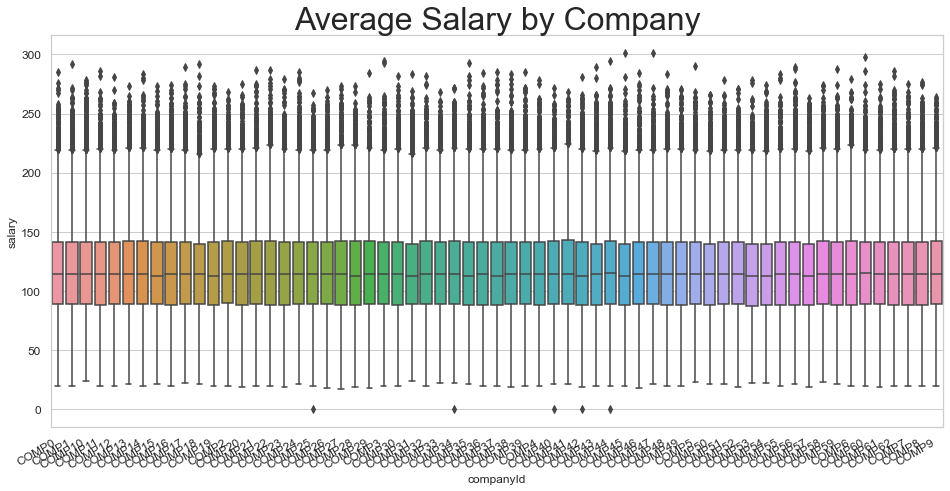

In [12]:
f, ax = plt.subplots(figsize=(16, 8))
plt.title("Average Salary by Company")
plt.xlabel("Company Number")
plt.ylabel("Average Salary")
sns.boxplot(x='companyId', y='salary', data=train_combined)
f.autofmt_xdate()
plt.show()

The next several plots are going to be violin plots, so here is a function to create violin plots.

In [13]:
def make_violinplot(x, y, data):
    """Creates a violin plot given a dataframe, x variable, and y variable.
    
        Inputs: x: string of x-variable
                y: string of y-variable
                data: dataframe
            
        Outputs: violinplot
    """
    
    order = data.groupby(x)[y].mean().sort_values().index.tolist()
    data[x].cat.reorder_categories(order, inplace=True)
    
    f, ax = plt.subplots(figsize=(8,8))
    plt.title(f'{y} by {x}')
    plt.xlabel(x)
    plt.ylabel(y)
    sns.violinplot(x=x, y=y, data=data)
    f.autofmt_xdate()

Plotting salary by job type.

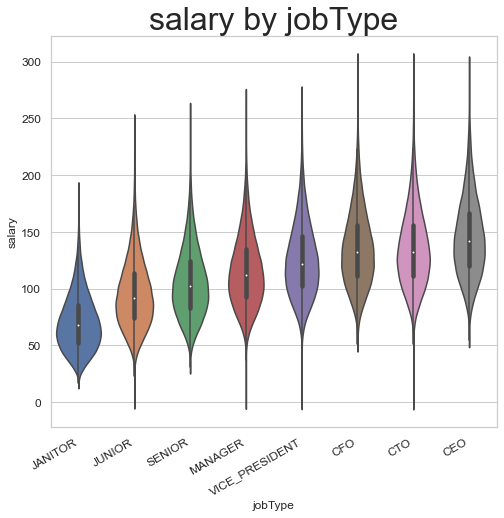

In [14]:
make_violinplot(x="jobType", y="salary", data=train_combined)

Plotting salary by degree.

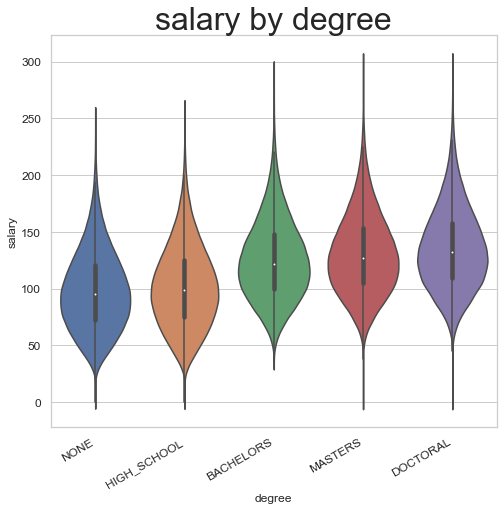

In [15]:
make_violinplot(x="degree", y="salary", data=train_combined)

Plotting salary by major in school.

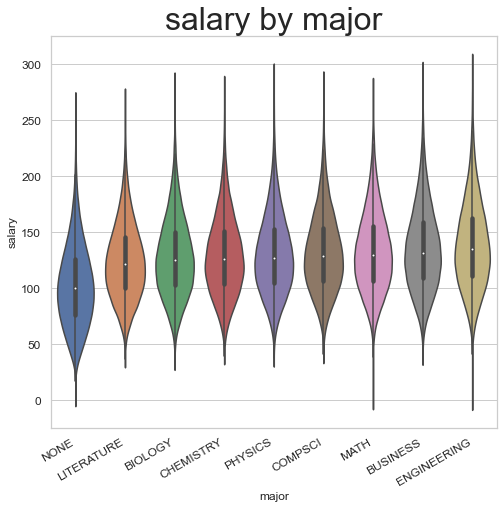

In [16]:
make_violinplot(x="major", y="salary", data=train_combined)

Plotting salary by industry.

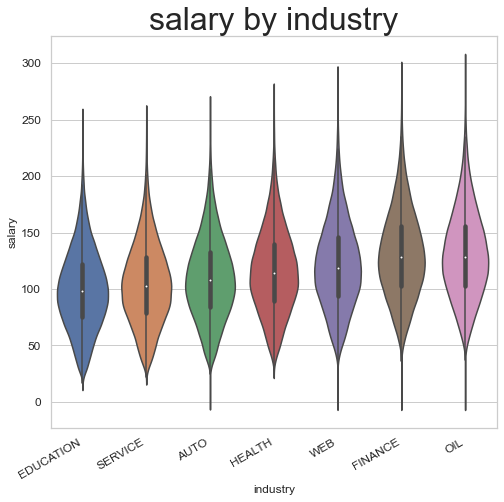

In [17]:
make_violinplot(x="industry", y="salary", data=train_combined)

Plotting Salary by years of experience.

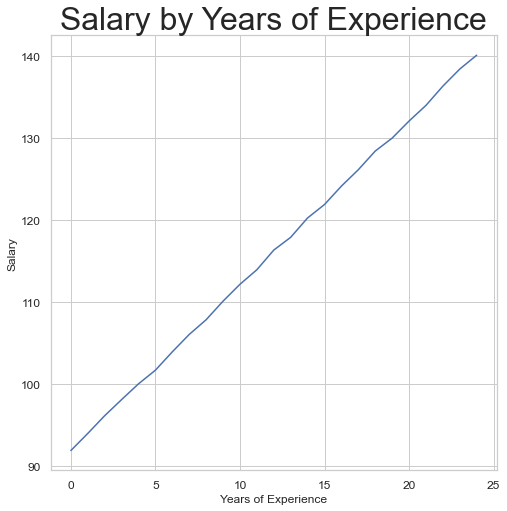

In [18]:
yoeCount = train_combined.groupby('yearsExperience').agg('mean')['salary']
f, ax = plt.subplots(figsize=(8, 8))
plt.title("Salary by Years of Experience")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.plot(yoeCount.index, yoeCount)
plt.show()

Plotting salary by miles from metropolis.

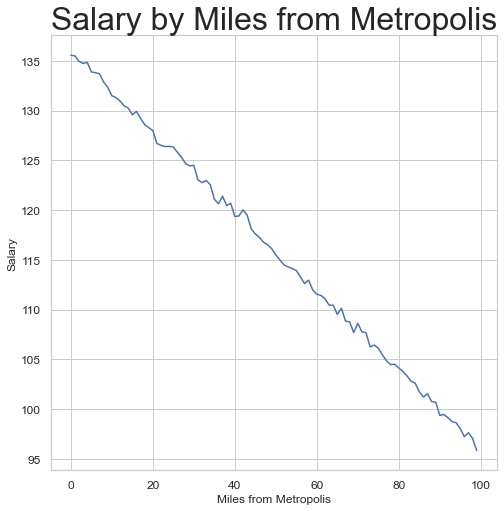

In [19]:
milesFromMetro = train_combined.groupby(
    'milesFromMetropolis').agg('mean')['salary']
f, ax = plt.subplots(figsize=(8, 8))
plt.title("Salary by Miles from Metropolis")
plt.xlabel("Miles from Metropolis")
plt.ylabel("Salary")
plt.plot(milesFromMetro.index, milesFromMetro)
plt.show()

Plotting the distribution of salaries.

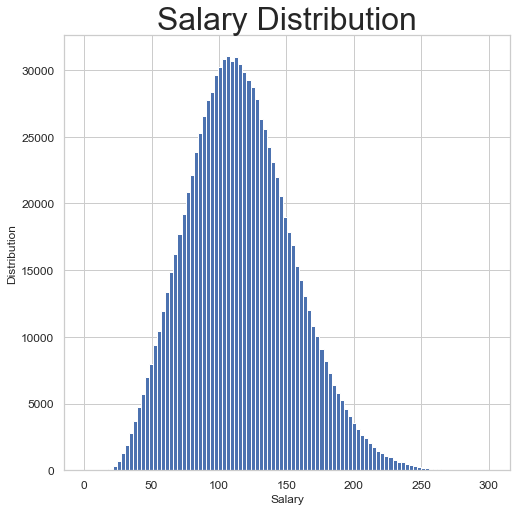

In [20]:
f, ax = plt.subplots(figsize=(8, 8))
plt.title("Salary Distribution")
plt.xlabel("Salary")
plt.ylabel("Distribution")
ax.hist(x=train_combined['salary'], bins=100)
plt.show()

Checking for outliers. The data are slightly skewed to the right. If applying the 1.5 IQR rule, the max of 301 would be an outlier, but it's worth keeping in because it's not an unrealistic salary. It is worth removing the 0 salaries, however, because I am not interested in measuring salary data for volunteers.

In [21]:
train_combined['salary'].describe()

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64

In [22]:
train_combined = train_combined[train_combined['salary'] > 0]

### ---- 5 Establish a baseline ----

In [23]:
# select a reasonable metric (MSE in this case)
# create an extremely simple model and measure its efficacy
# e.g. use "average salary" for each industry as your model and then measure MSE
# during 5-fold cross-validation

In [24]:
train_combined['average_salary'] = train_combined.groupby(
    'industry')['salary'].transform('mean')

In [25]:
baseline_X = np.array(train_combined['average_salary']).reshape(-1, 1)
baseline_y = np.array(train_combined['salary'])

scores = []
cv = KFold(n_splits=5, shuffle=False)
for train_index, test_index in cv.split(baseline_X):
    X_train, X_test, y_train, y_test = baseline_X[train_index], baseline_X[
        test_index], baseline_y[train_index], baseline_y[test_index]
    lr = LinearRegression().fit(X=X_train, y=y_train)
    scores.append(mean_squared_error(X_test, y_test))
print(scores)

[1369.1806222423513, 1368.6023543911754, 1371.3591525123234, 1362.2162691114431, 1364.2563556689843]


### ---- 6 Hypothesize solution ----

<h3>Model Ideas</h3>
<ol>
    <li>Linear Regression</li>
    <li>Random Forest</li>
    <li>Gradient Boosting Trees</li>
</ol>

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

<h3>Feature engineering steps</h3>
<ol>
    <li>One hot encoding categorical variables</li>
    <li>Standardizing numerical variables</li>
</ol>

In [26]:
X = train_combined.drop(['average_salary', 'salary', 'companyId'], axis=1)
y = train_combined['salary']
encoded_labels = ['jobType', 'degree', 'major', 'industry']

In [27]:
X = pd.get_dummies(X, prefix_sep="_", columns=encoded_labels)
X[['yearsExperience', 'milesFromMetropolis']] = StandardScaler().fit_transform(X[['yearsExperience', 'milesFromMetropolis']])

Running a correlation matrix on the continuous quantitative variables to see if any variable can be removed or merged together by Principal Component Analysis (PCA).

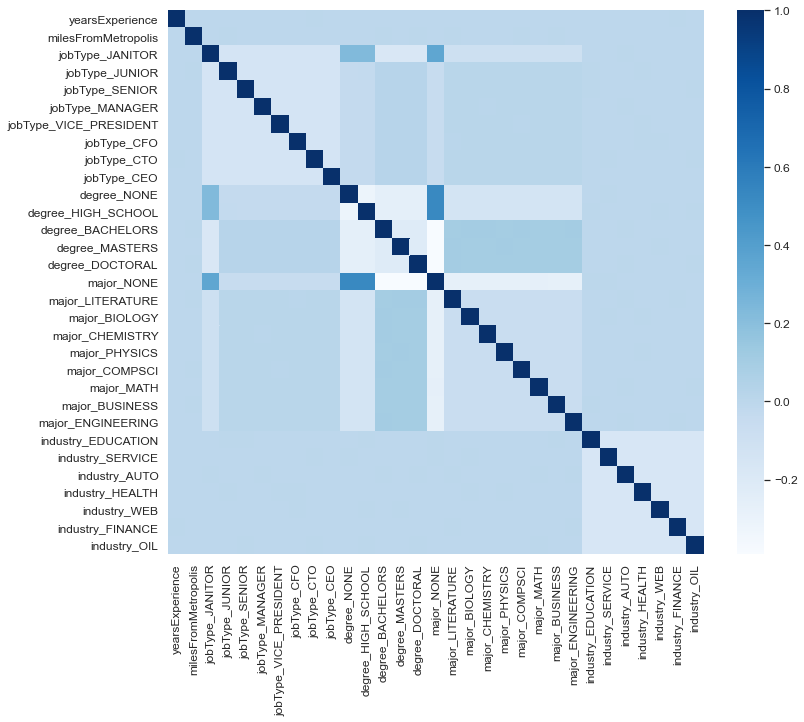

In [28]:
fig = plt.figure(figsize=(12, 10))
features = sns.heatmap(X.corr(), cmap='Blues')
f.autofmt_xdate()
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### ---- 8 Develop models ----

Linear Regression (official baseline model)

In [30]:
lr = LinearRegression(n_jobs=-1)
predictions = lr.fit(X_train, y_train).predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Linear Regression:", round(mse, 2))

Linear Regression: 383.44


Linear Regression with Interaction Features

In [31]:
from sklearn.preprocessing import PolynomialFeatures
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_inter = interaction.fit_transform(X_train)
X_test_inter = interaction.fit_transform(X_test)
lr_interaction = LinearRegression()
predictions = lr_interaction.fit(X_train_inter, y_train).predict(X_test_inter)
mse = mean_squared_error(y_test, predictions)
print("Linear Regression with Interaction:", round(mse, 2))

Linear Regression with Interaction: 353.39


Random Forest Model

In [32]:
rf = RandomForestRegressor(criterion='mse')

# Create the parameter grid
param_grid = {'n_estimators': [10],
              'max_depth': [x for x in range(5, 25)],
              'max_features': [.2, "sqrt", "log2"]}
verbose_lvl = 5

rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_jobs=-1, n_iter=25,
                                   verbose=5, return_train_score=True, cv=2, scoring='neg_mean_squared_error')
predictions = rf_random_search.fit(X_train, y_train).predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Random Forest:", round(mse, 2))

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.1min finished


Random Forest: 383.65


In [33]:
print("Max Depth: ", rf_random_search.best_params_['max_depth'])
print("Max Features: ", rf_random_search.best_params_['max_features'])

Max Depth:  17
Max Features:  0.2


In [34]:
# Random Forest with more estimators

rf = RandomForestRegressor(n_estimators=100, 
                                        criterion='mse', 
                                        max_depth=rf_random_search.best_params_['max_depth'], 
                                        max_features=rf_random_search.best_params_['max_features'],
                                        n_jobs=-1)

predictions = rf.fit(X_train, y_train).predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Random Forest with Tuning: ", round(mse, 2))

Random Forest with Tuning:  372.73


In [35]:
rf_random_search.best_params_

{'n_estimators': 10, 'max_features': 0.2, 'max_depth': 17}

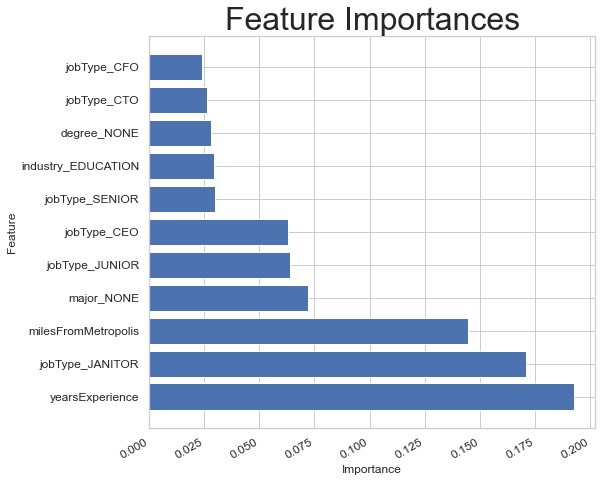

In [36]:
feature_importances = pd.DataFrame(zip(list(
    X.columns), rf.feature_importances_), columns=("Feature", "Importance")).sort_values(by="Importance", ascending=False)[0:11]
f, ax = plt.subplots(figsize=(8, 8))
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.barh(feature_importances["Feature"], feature_importances["Importance"])
f.autofmt_xdate()
plt.show()

Gradient Boosting Trees

In [37]:
param_grid = {'learning_rate':np.linspace(.01, .3, 30), 
              'max_depth':[x for x in range(3, 9)], 
              'n_estimators':[10], 
              'max_features':[.2, 'sqrt', 'log2'],
              'alpha':np.linspace(.01, .99, 100),
              'warm_start':[True]
              }
gbm = GradientBoostingRegressor()
gbm_random_search = RandomizedSearchCV(gbm, 
                                   param_distributions=param_grid, 
                                   n_jobs=-1, 
                                   verbose=5,
                                   n_iter=100,
                                   cv=2,
                                   return_train_score=True,
                                   scoring='neg_mean_squared_error'
                                   )

predictions = gbm_random_search.fit(X_train, y_train).predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("GBM: ", round(mse, 2))

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.3min finished


GBM:  425.34


In [38]:
gbm_random_search.best_params_

{'warm_start': True,
 'n_estimators': 10,
 'max_features': 0.2,
 'max_depth': 8,
 'learning_rate': 0.24999999999999997,
 'alpha': 0.2673737373737374}

In [39]:
gbm = GradientBoostingRegressor(warm_start=True, 
                                n_estimators=100, 
                                max_features=gbm_random_search.best_params_['max_features'], 
                                max_depth=gbm_random_search.best_params_['max_depth'], 
                                learning_rate=gbm_random_search.best_params_['learning_rate'], 
                                alpha=gbm_random_search.best_params_['alpha'],
                                )
predictions = gbm.fit(X_train, y_train).predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("GBM with Tuning: ", round(mse, 2))

GBM with Tuning:  361.13


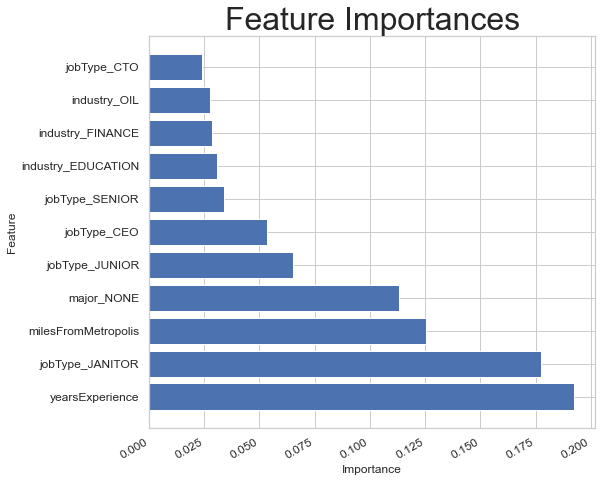

In [40]:
feature_importances = pd.DataFrame(zip(list(
    X.columns), gbm.feature_importances_), columns=("Feature", "Importance")).sort_values(by="Importance", ascending=False)[0:11]
f, ax = plt.subplots(figsize=(8, 8))
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.barh(feature_importances["Feature"], feature_importances["Importance"])
f.autofmt_xdate()
plt.show()

### ---- 9 Test models ----

In [41]:
# do 5-fold cross validation on models and measure MSE

Testing Linear Regression

In [42]:
cv_score = np.mean(-1 * cross_val_score(lr, X, y, cv=5, n_jobs=-1, scoring='neg_mean_squared_error'))
print(round(cv_score, 2))

384.42


Testing Linear Regression with Interaction

In [43]:
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_inter = interaction.fit_transform(X)
X_test_inter = interaction.fit_transform(X_test)
lr_interaction = LinearRegression()
cv_score = np.mean(-1 * cross_val_score(lr_interaction, X_inter, y, cv=5, n_jobs=-1, scoring='neg_mean_squared_error'))
print(round(cv_score, 2))

354.03


Testing Random Forest

In [44]:
cv_score = np.mean(-1 * cross_val_score(rf, X, y, cv=5, n_jobs=-1, scoring='neg_mean_squared_error'))
print(round(cv_score, 2))

373.5


Testing Gradient Boosting Trees

In [45]:
cv_score = np.mean(-1 * cross_val_score(gbm, X, y, cv=5, n_jobs=-1, scoring='neg_mean_squared_error'))
print(round(cv_score, 2))

361.55


### ---- 10 Select best model  ----

In [46]:
# select the model with the lowest error as your "production" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [47]:
# write script that trains model on entire training set, saves model to disk,
# and scores the "test" dataset

### ---- 12 Deploy solution ----

In [48]:
# save your prediction to a csv file or optionally save them as a table in a SQL database
# additionally, you want to save a visualization and summary of your prediction and feature importances
# these visualizations and summaries will be extremely useful to business stakeholders

In [49]:
predictions = pd.DataFrame(lr_interaction.fit(X_inter, y).predict(X_inter))

In [50]:
predictions.to_csv("Predictions.csv")

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data